In [2]:
%load_ext jupyter_black
import torch
import torch.optim as optim
import torch.nn as nn
from optimizers.lrmsprop import LRMSprop
from optimizers.ladam import LAdam
from optimizers.ladadelta import LAdadelta
from optimizers.lsgd import APLSGD
from optimizers.ladagrad import LAdagrad
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from training.train import train, plot_langevin_loss
from diffusion.fishing import Fishing
from scheduler import PiecewiseConstantScheduler
import os

plt.style.use(["science", "no-latex", "grid"])

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In this problem, we model the fish biomass $X_t\in\mathbb R^{d_1}$ by the following diffusion : 
$$dX_t = X_t \odot \left( (r - u_t - \kappa X_t)dt + \eta dW_t\right)\;, \;\;t\in [0, T]$$
Where $u_t\in\mathbb R^{d_1}$ represents the controlled fishing, and is contrained within $[u_m, u_M]^{d_1}$. We wish to keep the biomass close to a target value $\mathcal X_t\in\mathbb R^{d_1}$. The objective is defined as follows :
$$J(u) := \mathbb E\left[\int_0^T\left(\left|X_t - \mathcal X_t\right|^2 - \langle \alpha, u_t\rangle\right)\,dt + \beta \left[u\right]^{0, T}\right]$$
The quantity $\left[u\right]^{0, T}$ is the quadratic variation of the $u$ and is approximated via $\left[u\right]^{0, T}\approx \sum_{k=0}^{N-1}\left|u_{t_{k+1}} - u_{t_k}\right|^2$. We worked in the same setting as the original paper:
$$d_1 = d_2 = 5, \;T=1,\;\mathcal X = 1_{\mathbb R^5}, \; r=2\times 1_{\mathbb R^5}, \; \eta=0.1\times I_5, \; \alpha = 0.01\times 1_{\mathbb R^5}, \; \beta = 0.1, \; u_m=0.1, \; u_M = 1.$$
and :
$$\kappa = \begin{bmatrix}
1.2 & -0.1 & 0 & 0 & -0.1 \\
0.2 & 1.2 & 0 & 0 & -0.1 \\
0 & 0.2 & 1.2 & -0.1 & 0 \\
0 & 0 & 0.1 & 1.2 & 0 \\
0.1 & 0.1 & 0 & 0 & 1.2 
\end{bmatrix}$$

In [3]:
train_batch = 512
test_batch = 512
train_size = 5
test_size = 25
epochs = 50

## Single control:

In [4]:
def test_diag_single_ctrl(
    model_config,
    N_euler,
    control_config,
    optim,
    langevin_optim,
    name,
    lr,
    target_lr,
    sigma,
    epochs,
    total_iters,
    **optim_kwargs,
):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    for i, N in enumerate(N_euler):
        # Vanilla algo
        ocp = Fishing(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=False)
        vanilla_optim = optim(ocp.control.parameters(), lr=lr, **optim_kwargs)
        scheduler = PiecewiseConstantScheduler(
            vanilla_optim, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        train_loss, test_loss, test_ci = train(
            ocp,
            vanilla_optim,
            scheduler,
            name,
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)), test_loss, marker="o", mec="k", ms=3, label=name
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        # Langevin algo
        ocp = Fishing(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=False)
        loptim = langevin_optim(ocp.control.parameters(), lr=lr, sigma=sigma[i])
        scheduler = PiecewiseConstantScheduler(
            loptim, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        train_loss, test_loss, test_ci = train(
            ocp,
            loptim,
            scheduler,
            f"L-{name}",
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)),
            test_loss,
            marker="o",
            mec="k",
            ms=3,
            label=f"L-{name}",
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        if i == 0:
            axs[i].set_ylabel(r"$J(u_\theta)$")
        axs[i].set_xlabel("Epochs")
        if i == 2:
            legend = axs[i].legend(fancybox=True, edgecolor="k", loc=0)
            legend.get_frame().set_linewidth(0.5)

    plt.show()
    plt.close()

    return fig

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dim = 5

model_config = dict(
    T=1.0,
    dim=dim,
    r=2 * torch.ones(dim).to(device),
    kappa=torch.Tensor(
        [
            [1.2, -0.1, 0.0, 0.0, -0.1],
            [0.2, 1.2, 0.0, 0.0, -0.1],
            [0.0, 0.2, 1.2, -0.1, 0.0],
            [0.0, 0.0, 0.1, 1.2, 0.0],
            [0.1, 0.1, 0.0, 0.0, 1.2],
        ]
    ).to(device),
    X_d=torch.ones(dim).to(device),
    u_m=0.01,
    u_M=1.0,
    alpha=0.01 * torch.ones(dim).to(device),
    beta=0.1,
    sigma=0.1 * torch.eye(dim).to(device),
    init_mean=torch.ones(dim).to(device),
    init_std=0.5,
    init_lbound=0.2,
    init_ubound=2,
    device=device,
)

control_config = dict(
    input_dim=1 + dim,
    output_dim=dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.Sigmoid(),
)

Fishing: Epoch 49, Adam, lr=0.000, sigma=0.000, train=0.323, test=0.325: 100%|██████████| 50/50 [00:09<00:00,  5.48it/s]
Fishing: Epoch 49, L-Adam, lr=0.000, sigma=0.000, train=0.300, test=0.297: 100%|██████████| 50/50 [00:10<00:00,  4.81it/s]
Fishing: Epoch 49, Adam, lr=0.000, sigma=0.000, train=0.359, test=0.352: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]
Fishing: Epoch 49, L-Adam, lr=0.000, sigma=0.000, train=0.284, test=0.287: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]
Fishing: Epoch 49, Adam, lr=0.000, sigma=0.000, train=0.339, test=0.337: 100%|██████████| 50/50 [00:34<00:00,  1.45it/s]
Fishing: Epoch 49, L-Adam, lr=0.000, sigma=0.000, train=0.290, test=0.288: 100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


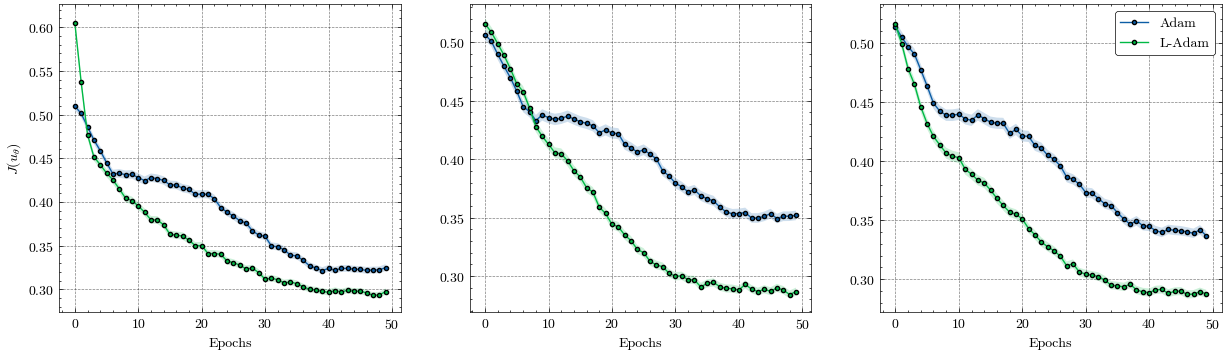

In [6]:
adam_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adam,
    LAdam,
    "Adam",
    2e-3,
    2e-4,
    [1e-3, 1e-3, 1e-3],
    50,
    40,
)

Fishing: Epoch 49, Adagrad, lr=0.001, sigma=0.000, train=0.347, test=0.349: 100%|██████████| 50/50 [00:10<00:00,  4.60it/s]
Fishing: Epoch 49, L-Adagrad, lr=0.001, sigma=0.000, train=0.297, test=0.289: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]
Fishing: Epoch 49, Adagrad, lr=0.001, sigma=0.000, train=0.349, test=0.347: 100%|██████████| 50/50 [00:18<00:00,  2.76it/s]
Fishing: Epoch 49, L-Adagrad, lr=0.001, sigma=0.000, train=0.324, test=0.328: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s]
Fishing: Epoch 49, Adagrad, lr=0.001, sigma=0.000, train=0.371, test=0.362: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s]
Fishing: Epoch 49, L-Adagrad, lr=0.001, sigma=0.000, train=0.316, test=0.313: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


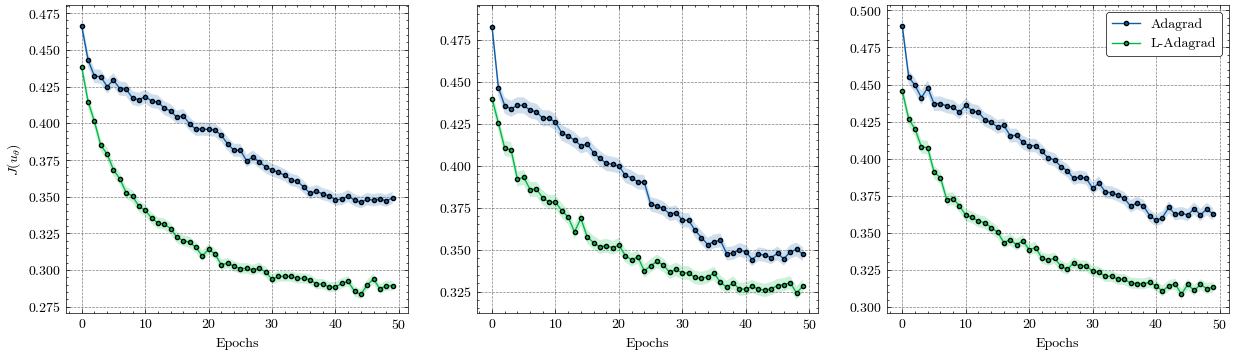

In [7]:
adagrad_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adagrad,
    LAdagrad,
    "Adagrad",
    1e-2,
    1e-3,
    [5e-5, 5e-5, 5e-5],
    50,
    40,
)

Fishing: Epoch 49, RMSprop, lr=0.000, sigma=0.000, train=0.296, test=0.295: 100%|██████████| 50/50 [00:13<00:00,  3.58it/s]
Fishing: Epoch 49, L-RMSprop, lr=0.000, sigma=0.000, train=0.285, test=0.279: 100%|██████████| 50/50 [00:13<00:00,  3.72it/s]
Fishing: Epoch 49, RMSprop, lr=0.000, sigma=0.000, train=0.301, test=0.303: 100%|██████████| 50/50 [00:21<00:00,  2.32it/s]
Fishing: Epoch 49, L-RMSprop, lr=0.000, sigma=0.000, train=0.285, test=0.286: 100%|██████████| 50/50 [00:20<00:00,  2.44it/s]
Fishing: Epoch 49, RMSprop, lr=0.000, sigma=0.000, train=0.298, test=0.307: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]
Fishing: Epoch 49, L-RMSprop, lr=0.000, sigma=0.000, train=0.293, test=0.286: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


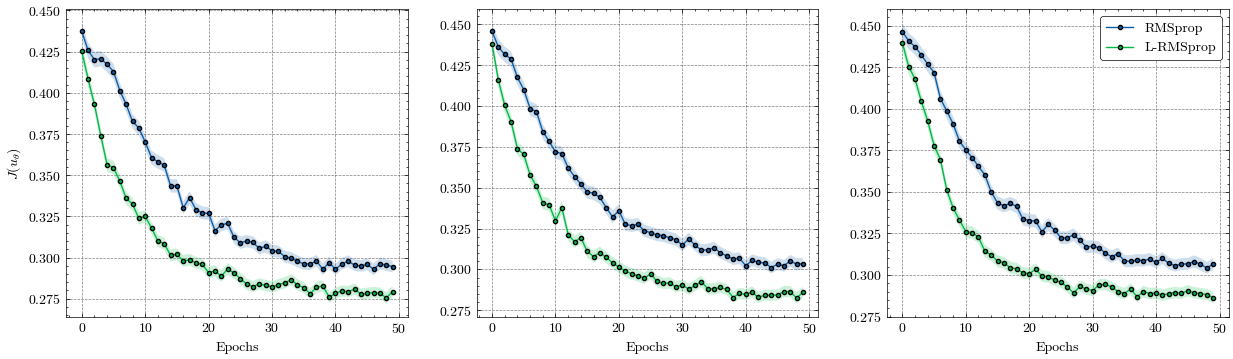

In [8]:
rmsprop_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.RMSprop,
    LRMSprop,
    "RMSprop",
    2e-3,
    2e-4,
    [5e-3, 5e-3, 5e-3],
    50,
    40,
)

Fishing: Epoch 49, Adadelta, lr=0.050, sigma=0.000, train=0.424, test=0.424: 100%|██████████| 50/50 [00:12<00:00,  4.10it/s]
Fishing: Epoch 49, L-Adadelta, lr=0.050, sigma=0.000, train=0.277, test=0.277: 100%|██████████| 50/50 [00:12<00:00,  4.11it/s]
Fishing: Epoch 49, Adadelta, lr=0.050, sigma=0.000, train=0.441, test=0.435: 100%|██████████| 50/50 [00:21<00:00,  2.29it/s]
Fishing: Epoch 49, L-Adadelta, lr=0.050, sigma=0.000, train=0.285, test=0.284: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]
Fishing: Epoch 49, Adadelta, lr=0.050, sigma=0.000, train=0.436, test=0.443: 100%|██████████| 50/50 [00:40<00:00,  1.25it/s]
Fishing: Epoch 49, L-Adadelta, lr=0.050, sigma=0.000, train=0.282, test=0.282: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


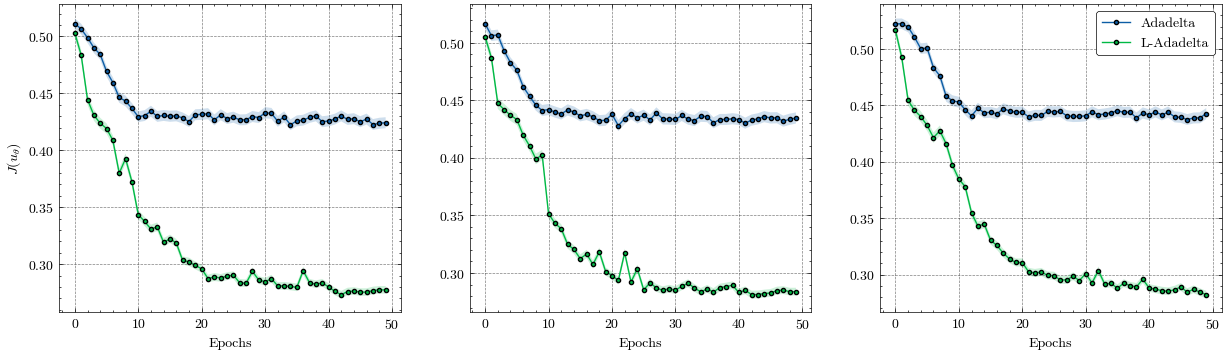

In [9]:
adadelta_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adadelta,
    LAdadelta,
    "Adadelta",
    5e-1,
    5e-2,
    [1e-2, 1e-2, 1e-2],
    50,
    40,
    rho=0.95,
)

Fishing: Epoch 49, SGD, lr=0.005, sigma=0.000, train=0.419, test=0.426: 100%|██████████| 50/50 [00:11<00:00,  4.17it/s]
Fishing: Epoch 49, L-SGD, lr=0.005, sigma=0.000, train=0.370, test=0.365: 100%|██████████| 50/50 [00:12<00:00,  4.09it/s]
Fishing: Epoch 49, SGD, lr=0.005, sigma=0.000, train=0.439, test=0.433: 100%|██████████| 50/50 [00:23<00:00,  2.17it/s]
Fishing: Epoch 49, L-SGD, lr=0.005, sigma=0.000, train=0.415, test=0.409: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s]
Fishing: Epoch 49, SGD, lr=0.005, sigma=0.000, train=0.441, test=0.444: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
Fishing: Epoch 49, L-SGD, lr=0.005, sigma=0.000, train=0.422, test=0.421: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


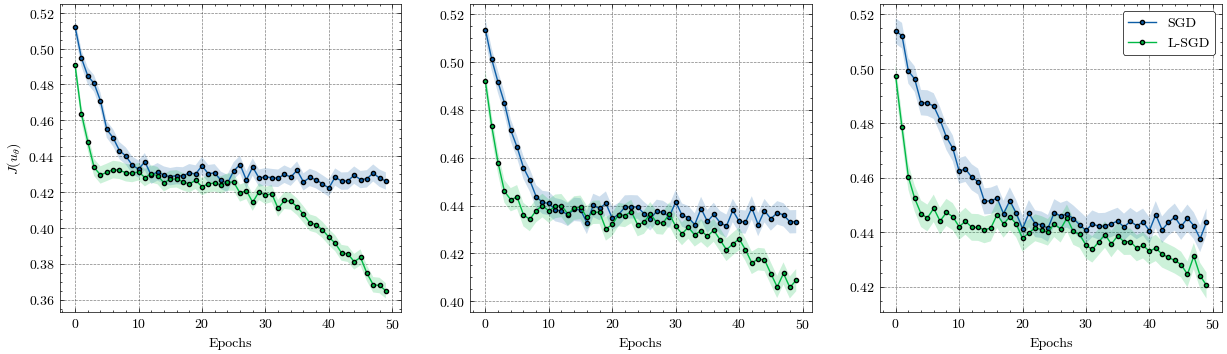

In [10]:
sgd_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.SGD,
    APLSGD,
    "SGD",
    5e-2,
    5e-3,
    [1e-3, 1e-3, 1e-3],
    50,
    40,
    momentum=0.9,
)

In [11]:
if os.path.isdir("graphs/fishing"):
    adam_single_ctrl.savefig("graphs/fishing/adam_single_ctrl.pdf")
    adadelta_single_ctrl.savefig("graphs/fishing/adadelta_single_ctrl.pdf")
    rmsprop_single_ctrl.savefig("graphs/fishing/rmsprop_single_ctrl.pdf")
    sgd_single_ctrl.savefig("graphs/fishing/sgd_single_ctrl.pdf")
    adagrad_single_ctrl.savefig("graphs/fishing/adagrad_single_ctrl.pdf")

### Multiple controls:

In [12]:
def test_diag_multiple_ctrls(
    model_config,
    N_euler,
    control_config,
    optim,
    langevin_optim,
    name,
    lr,
    target_lr,
    sigma,
    ll,
    epochs,
    total_iters,
    **optim_kwargs,
):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    for i, N in enumerate(N_euler):
        # Vanilla algo
        ocp = Fishing(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=True)
        vanilla_optim = [
            optim(control.parameters(), lr=lr, **optim_kwargs)
            for control in ocp.control
        ]
        scheduler = [
            PiecewiseConstantScheduler(
                optimizer, target_lr=target_lr, target_sigma=0, total_iters=total_iters
            )
            for optimizer in vanilla_optim
        ]
        train_loss, test_loss, test_ci = train(
            ocp,
            vanilla_optim,
            scheduler,
            name,
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)), test_loss, marker="o", mec="k", ms=3, label=name
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        # Langevin algo
        ocp = Fishing(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=True)
        loptim = [
            langevin_optim(control.parameters(), lr=lr, sigma=sigma[i])
            for control in ocp.control
        ]
        scheduler = [
            PiecewiseConstantScheduler(
                optimizer, target_lr=target_lr, target_sigma=0, total_iters=total_iters
            )
            for optimizer in loptim
        ]
        train_loss, test_loss, test_ci = train(
            ocp,
            loptim,
            scheduler,
            f"L-{name}",
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)),
            test_loss,
            marker="o",
            mec="k",
            ms=3,
            label=f"L-{name}",
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        # Layer Langevin algo
        for ll_rate in ll:
            ocp = Fishing(**model_config, N_euler=N)
            ocp.set_control(control_config, multiple_controls=True)
            lloptim = []
            scheduler = []
            for j, control in enumerate(ocp.control):
                if 100 * j / len(ocp.control) <= ll_rate:
                    lloptim.append(
                        langevin_optim(control.parameters(), lr=lr, sigma=sigma[i])
                    )
                else:
                    lloptim.append(optim(control.parameters(), lr=lr, **optim_kwargs))
                scheduler.append(
                    PiecewiseConstantScheduler(
                        lloptim[j],
                        target_lr=target_lr,
                        target_sigma=0,
                        total_iters=total_iters,
                    )
                )
            train_loss, test_loss, test_ci = train(
                ocp,
                lloptim,
                scheduler,
                f"LL-{name} {ll_rate}%",
                epochs,
                train_size,
                test_size,
                train_batch,
                test_batch,
            )
            axs[i].plot(
                np.arange(len(test_loss)),
                test_loss,
                marker="o",
                mec="k",
                ms=3,
                label=f"LL-{name} {ll_rate}%",
            )
            axs[i].fill_between(
                np.arange(len(test_loss)),
                np.array(test_loss) - np.array(test_ci),
                np.array(test_loss) + np.array(test_ci),
                alpha=0.2,
            )

        if i == 0:
            axs[i].set_ylabel(r"$J(u_\theta)$")
        axs[i].set_xlabel("Epochs")
        if i == 2:
            legend = axs[i].legend(fancybox=True, edgecolor="k", loc=0)
            legend.get_frame().set_linewidth(0.5)

    plt.show()
    plt.close()

    return fig

In [13]:
dim = 5

model_config = dict(
    T=1.0,
    dim=dim,
    r=2 * torch.ones(dim),
    kappa=torch.Tensor(
        [
            [1.2, -0.1, 0.0, 0.0, -0.1],
            [0.2, 1.2, 0.0, 0.0, -0.1],
            [0.0, 0.2, 1.2, -0.1, 0.0],
            [0.0, 0.0, 0.1, 1.2, 0.0],
            [0.1, 0.1, 0.0, 0.0, 1.2],
        ]
    ).to(device),
    X_d=torch.ones(dim).to(device),
    u_m=0.01,
    u_M=1.0,
    alpha=0.01 * torch.ones(dim).to(device),
    beta=0.1,
    sigma=0.1 * torch.eye(dim).to(device),
    init_mean=torch.ones(dim).to(device),
    init_std=0.5,
    init_lbound=0.2,
    init_ubound=2,
    device=device,
)

control_config = dict(
    input_dim=5,
    output_dim=5,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.Sigmoid(),
    seed=1337,
)

Fishing: Epoch 49, Adam, lr=0.000, sigma=0.000, train=0.320, test=0.313: 100%|██████████| 50/50 [00:06<00:00,  7.91it/s]
Fishing: Epoch 49, L-Adam, lr=0.000, sigma=0.000, train=0.275, test=0.282: 100%|██████████| 50/50 [00:06<00:00,  7.27it/s]
Fishing: Epoch 49, LL-Adam 30%, lr=0.000, sigma=0.000, train=0.288, test=0.286: 100%|██████████| 50/50 [00:06<00:00,  7.87it/s]
Fishing: Epoch 49, LL-Adam 90%, lr=0.000, sigma=0.000, train=0.275, test=0.271: 100%|██████████| 50/50 [00:07<00:00,  6.82it/s]
Fishing: Epoch 49, Adam, lr=0.000, sigma=0.000, train=0.354, test=0.347: 100%|██████████| 50/50 [00:12<00:00,  4.13it/s]
Fishing: Epoch 49, L-Adam, lr=0.000, sigma=0.000, train=0.315, test=0.313: 100%|██████████| 50/50 [00:12<00:00,  3.90it/s]
Fishing: Epoch 49, LL-Adam 30%, lr=0.000, sigma=0.000, train=0.326, test=0.324: 100%|██████████| 50/50 [00:13<00:00,  3.81it/s]
Fishing: Epoch 49, LL-Adam 90%, lr=0.000, sigma=0.000, train=0.314, test=0.318: 100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


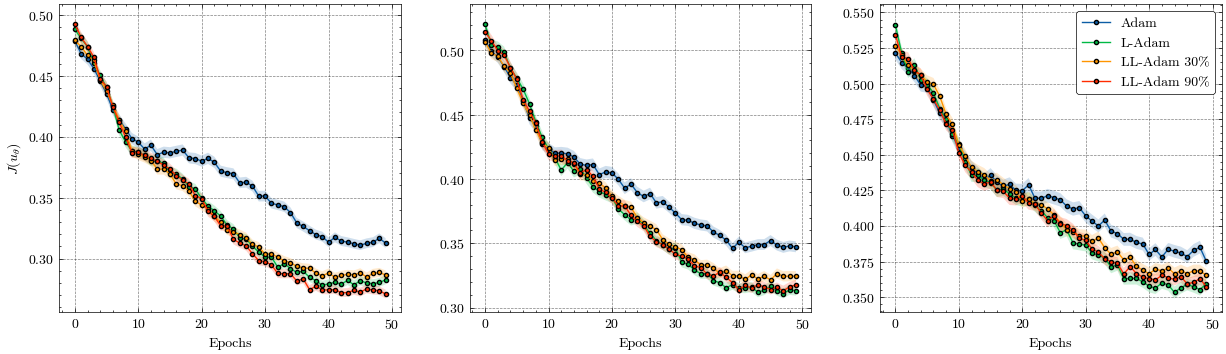

In [14]:
adam_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.Adam,
    LAdam,
    "Adam",
    2e-3,
    2e-4,
    [2e-4, 2e-4, 2e-4],
    [30, 90],
    50,
    40,
)

Fishing: Epoch 49, Adagrad, lr=0.001, sigma=0.000, train=0.354, test=0.360: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]
Fishing: Epoch 49, L-Adagrad, lr=0.001, sigma=0.000, train=0.331, test=0.326: 100%|██████████| 50/50 [00:06<00:00,  7.40it/s]
Fishing: Epoch 49, LL-Adagrad 30%, lr=0.001, sigma=0.000, train=0.342, test=0.342: 100%|██████████| 50/50 [00:06<00:00,  7.91it/s]
Fishing: Epoch 49, LL-Adagrad 90%, lr=0.001, sigma=0.000, train=0.334, test=0.335: 100%|██████████| 50/50 [00:06<00:00,  7.71it/s]
Fishing: Epoch 49, Adagrad, lr=0.001, sigma=0.000, train=0.407, test=0.403: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]
Fishing: Epoch 49, L-Adagrad, lr=0.001, sigma=0.000, train=0.395, test=0.386: 100%|██████████| 50/50 [00:12<00:00,  3.86it/s]
Fishing: Epoch 49, LL-Adagrad 30%, lr=0.001, sigma=0.000, train=0.389, test=0.391: 100%|██████████| 50/50 [00:11<00:00,  4.28it/s]
Fishing: Epoch 49, LL-Adagrad 90%, lr=0.001, sigma=0.000, train=0.393, test=0.387: 100%|██████████| 50/50 [

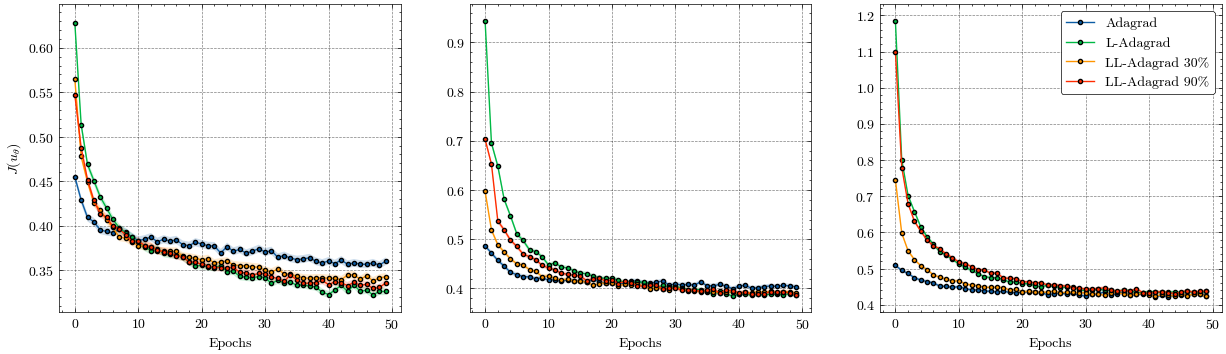

In [15]:
adagrad_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.Adagrad,
    LAdagrad,
    "Adagrad",
    1e-2,
    1e-3,
    [5e-5, 5e-5, 5e-5],
    [30, 90],
    50,
    40,
)

Fishing: Epoch 49, Adadelta, lr=0.050, sigma=0.000, train=0.421, test=0.434: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]
Fishing: Epoch 49, L-Adadelta, lr=0.050, sigma=0.000, train=0.370, test=0.369: 100%|██████████| 50/50 [00:07<00:00,  6.52it/s]
Fishing: Epoch 49, LL-Adadelta 30%, lr=0.050, sigma=0.000, train=0.383, test=0.385: 100%|██████████| 50/50 [00:08<00:00,  6.18it/s]
Fishing: Epoch 49, LL-Adadelta 90%, lr=0.050, sigma=0.000, train=0.368, test=0.376: 100%|██████████| 50/50 [00:07<00:00,  6.47it/s]
Fishing: Epoch 49, Adadelta, lr=0.050, sigma=0.000, train=0.482, test=0.477: 100%|██████████| 50/50 [00:13<00:00,  3.68it/s]
Fishing: Epoch 49, L-Adadelta, lr=0.050, sigma=0.000, train=0.420, test=0.416: 100%|██████████| 50/50 [00:14<00:00,  3.48it/s]
Fishing: Epoch 49, LL-Adadelta 30%, lr=0.050, sigma=0.000, train=0.432, test=0.436: 100%|██████████| 50/50 [00:13<00:00,  3.74it/s]
Fishing: Epoch 49, LL-Adadelta 90%, lr=0.050, sigma=0.000, train=0.423, test=0.419: 100%|██████████|

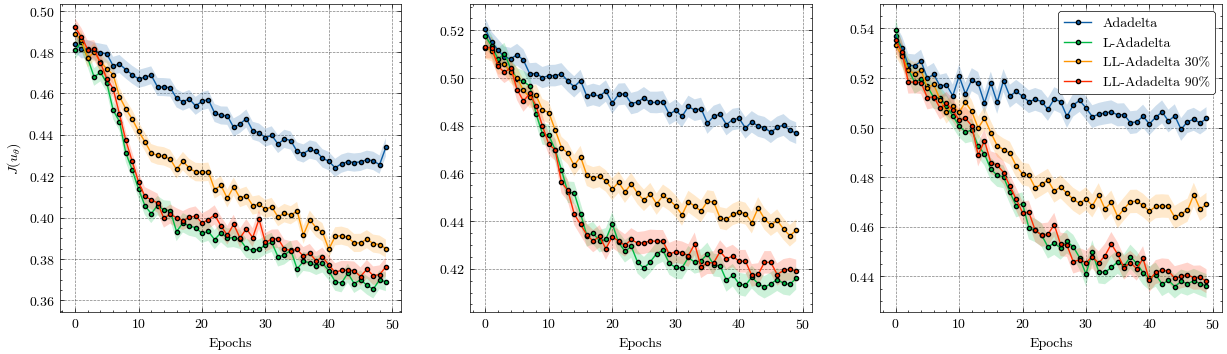

In [16]:
adadelta_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.Adadelta,
    LAdadelta,
    "Adadelta",
    5e-1,
    5e-2,
    [5e-3, 5e-3, 5e-3],
    [30, 90],
    50,
    40,
    rho=0.95,
)

Fishing: Epoch 49, RMSprop, lr=0.000, sigma=0.000, train=0.347, test=0.343: 100%|██████████| 50/50 [00:06<00:00,  7.95it/s]
Fishing: Epoch 49, L-RMSprop, lr=0.000, sigma=0.000, train=0.306, test=0.300: 100%|██████████| 50/50 [00:06<00:00,  7.21it/s]
Fishing: Epoch 49, LL-RMSprop 30%, lr=0.000, sigma=0.000, train=0.315, test=0.316: 100%|██████████| 50/50 [00:06<00:00,  7.96it/s]
Fishing: Epoch 49, LL-RMSprop 90%, lr=0.000, sigma=0.000, train=0.306, test=0.308: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s]
Fishing: Epoch 49, RMSprop, lr=0.000, sigma=0.000, train=0.396, test=0.402: 100%|██████████| 50/50 [00:11<00:00,  4.53it/s]
Fishing: Epoch 49, L-RMSprop, lr=0.000, sigma=0.000, train=0.364, test=0.363: 100%|██████████| 50/50 [00:10<00:00,  4.62it/s]
Fishing: Epoch 49, LL-RMSprop 30%, lr=0.000, sigma=0.000, train=0.372, test=0.371: 100%|██████████| 50/50 [00:10<00:00,  4.97it/s]
Fishing: Epoch 49, LL-RMSprop 90%, lr=0.000, sigma=0.000, train=0.364, test=0.366: 100%|██████████| 50/50 [

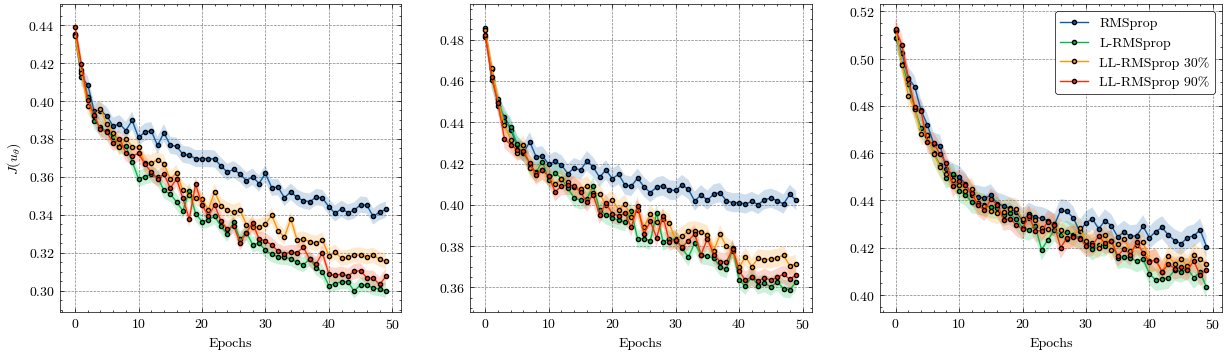

In [17]:
rmsprop_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.RMSprop,
    LRMSprop,
    "RMSprop",
    2e-3,
    2e-4,
    [2e-3, 2e-3, 2e-3],
    [30, 90],
    50,
    40,
)

Fishing: Epoch 49, SGD, lr=0.005, sigma=0.000, train=0.427, test=0.426: 100%|██████████| 50/50 [00:06<00:00,  8.08it/s]
Fishing: Epoch 49, L-SGD, lr=0.005, sigma=0.000, train=0.402, test=0.398: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Fishing: Epoch 49, LL-SGD 30%, lr=0.005, sigma=0.000, train=0.411, test=0.411: 100%|██████████| 50/50 [00:06<00:00,  7.88it/s]
Fishing: Epoch 49, LL-SGD 90%, lr=0.005, sigma=0.000, train=0.403, test=0.402: 100%|██████████| 50/50 [00:06<00:00,  7.61it/s]
Fishing: Epoch 49, SGD, lr=0.005, sigma=0.000, train=0.484, test=0.481: 100%|██████████| 50/50 [00:10<00:00,  4.73it/s]
Fishing: Epoch 49, L-SGD, lr=0.005, sigma=0.000, train=0.446, test=0.443: 100%|██████████| 50/50 [00:12<00:00,  4.14it/s]
Fishing: Epoch 49, LL-SGD 30%, lr=0.005, sigma=0.000, train=0.458, test=0.454: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]
Fishing: Epoch 49, LL-SGD 90%, lr=0.005, sigma=0.000, train=0.441, test=0.438: 100%|██████████| 50/50 [00:11<00:00,  4.23it/s]
Fishing:

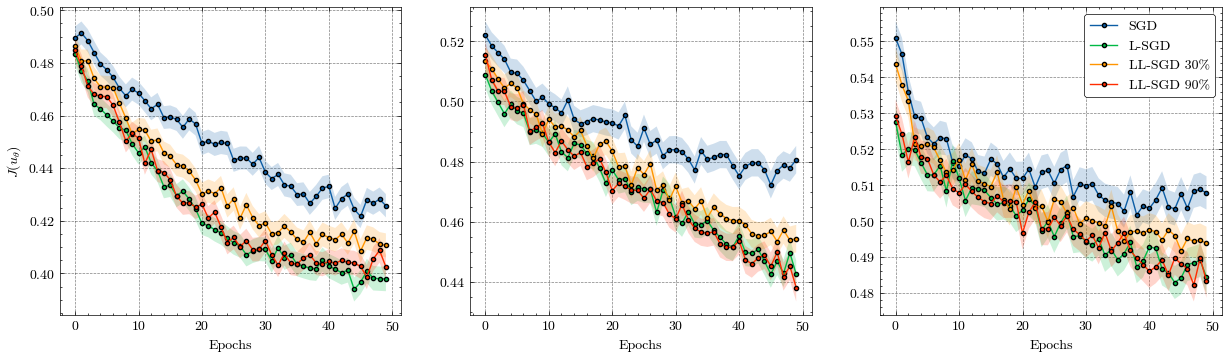

In [18]:
sgd_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.SGD,
    APLSGD,
    "SGD",
    5e-2,
    5e-3,
    [2e-3, 2e-3, 2e-3],
    [30, 90],
    50,
    40,
    momentum=0.9,
)

In [19]:
if os.path.isdir("graphs/fishing"):
    adam_multiple_ctrl.savefig("graphs/fishing/adam_multiple_ctrl.pdf")
    adadelta_multiple_ctrl.savefig("graphs/fishing/adadelta_multiple_ctrl.pdf")
    rmsprop_multiple_ctrl.savefig("graphs/fishing/rmsprop_multiple_ctrl.pdf")
    sgd_multiple_ctrl.savefig("graphs/fishing/sgd_multiple_ctrl.pdf")
    adagrad_multiple_ctrl.savefig("graphs/fishing/adagrad_multiple_ctrl.pdf")

### Sample trajectory:

In [20]:
dim = 5

model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    r=2 * torch.ones(dim),
    kappa=torch.Tensor(
        [
            [1.2, -0.1, 0.0, 0.0, -0.1],
            [0.2, 1.2, 0.0, 0.0, -0.1],
            [0.0, 0.2, 1.2, -0.1, 0.0],
            [0.0, 0.0, 0.1, 1.2, 0.0],
            [0.1, 0.1, 0.0, 0.0, 1.2],
        ]
    ).to(device),
    X_d=torch.ones(dim).to(device),
    u_m=0.01,
    u_M=1.0,
    alpha=0.01 * torch.ones(dim).to(device),
    beta=0.1,
    sigma=0.1 * torch.eye(dim).to(device),
    init_mean=torch.ones(dim).to(device),
    init_std=0.5,
    init_lbound=0.2,
    init_ubound=2,
    device=device,
)

control_config = dict(
    input_dim=1 + dim,
    output_dim=dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.Sigmoid(),
)

In [21]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam = optim.Adam(ocp.control.parameters(), lr=2e-3)
scheduler = PiecewiseConstantScheduler(
    adam, target_lr=2e-4, target_sigma=0, total_iters=40
)

train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp, adam, scheduler, "Adam", epochs, train_size, test_size, train_batch, test_batch
)

Fishing: Epoch 49, Adam, lr=0.000, sigma=0.000, train=0.331, test=0.330: 100%|██████████| 50/50 [00:25<00:00,  1.92it/s]


In [39]:
X, u = ocp.sample_traj(1)

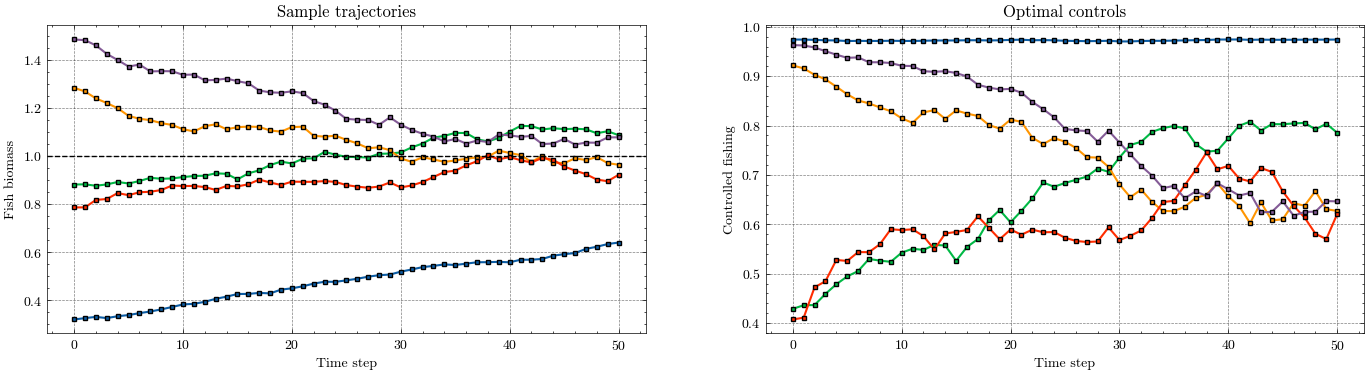

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 4))

for k in range(X.shape[2]):
    ax1.plot(X[:, :, k].flatten().detach().numpy(), lw=1.5, marker="s", mec="k", ms=3)
    ax2.plot(u[:, :, k].flatten().detach().numpy(), lw=1.5, marker="s", mec="k", ms=3)
ax1.axhline(1, linestyle="--", color="k")
ax1.set_title("Sample trajectories")
ax1.set_xlabel("Time step")
ax1.set_ylabel("Fish biomass")
ax2.set_title("Optimal controls")
ax2.set_xlabel("Time step")
ax2.set_ylabel("Controlled fishing")
# fig.savefig("graphs/fishing/Sample_traj_fishing_N50.pdf")
plt.show()
plt.close()

### Different architectures for the control

In [24]:
dim = 5

model_config = dict(
    T=1.0,
    dim=dim,
    r=2 * torch.ones(dim),
    kappa=torch.Tensor(
        [
            [1.2, -0.1, 0.0, 0.0, -0.1],
            [0.2, 1.2, 0.0, 0.0, -0.1],
            [0.0, 0.2, 1.2, -0.1, 0.0],
            [0.0, 0.0, 0.1, 1.2, 0.0],
            [0.1, 0.1, 0.0, 0.0, 1.2],
        ]
    ),
    X_d=torch.ones(dim),
    u_m=0.01,
    u_M=1.0,
    alpha=0.01 * torch.ones(dim),
    beta=0.1,
    sigma=0.1 * torch.eye(dim),
    init_mean=torch.ones(dim),
    init_std=0.5,
    init_lbound=0.2,
    init_ubound=2,
)

control_config = dict(
    input_dim=1 + dim,
    output_dim=dim,
    hidden_dim=32,
    depth=4,
    activation=nn.SiLU(),
    out_transform=nn.Sigmoid(),
)

Fishing: Epoch 49, Adam, lr=0.000, sigma=0.000, train=0.320, test=0.318: 100%|██████████| 50/50 [00:28<00:00,  1.76it/s]
Fishing: Epoch 49, L-Adam, lr=0.000, sigma=0.000, train=0.311, test=0.312: 100%|██████████| 50/50 [00:27<00:00,  1.84it/s]
Fishing: Epoch 49, Adam, lr=0.000, sigma=0.000, train=0.323, test=0.320: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]
Fishing: Epoch 49, L-Adam, lr=0.000, sigma=0.000, train=0.309, test=0.314: 100%|██████████| 50/50 [00:37<00:00,  1.32it/s]
Fishing: Epoch 49, Adam, lr=0.000, sigma=0.000, train=0.337, test=0.343: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]
Fishing: Epoch 49, L-Adam, lr=0.000, sigma=0.000, train=0.323, test=0.321: 100%|██████████| 50/50 [01:08<00:00,  1.36s/it]


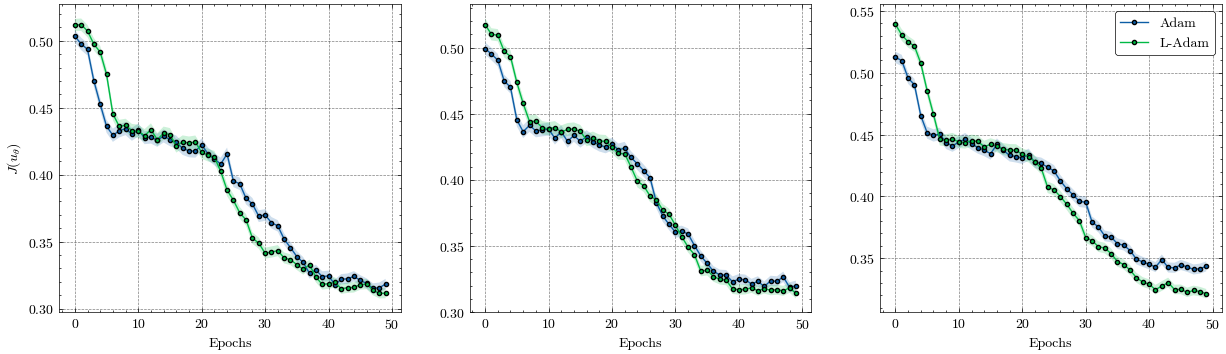

In [25]:
adam_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adam,
    LAdam,
    "Adam",
    2e-3,
    2e-4,
    [1e-3, 1e-3, 1e-3],
    50,
    40,
)